In [129]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import imblearn
from imblearn.over_sampling import SMOTE, SMOTENC

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier, Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report

In [130]:
data = pd.read_parquet("../data/df_cleaned.parquet")
data

,transaction_date,amount,memo,new_category,Cleaned Text
8,2018-03-06,15.25,POS CASINO BAR @ SPOTL - MEMO=PURCHASE 03/02 C...,Entertainment,pos casino bar spotl memopurchase 0302 coache...
39,2018-09-29,16.04,BEST BUY GRAND REGENCY BRANDON F,General Merchandise,best buy grand regency brandon f
45,2018-10-17,10.36,CORNER STORE ARLINGTON TX 10/17 Purchase $5.3...,Automotive,corner store arlington tx 1017 purchase $536 ...
52,2017-07-11,4.63,SPEEDWAY IN BEDFORD IN 07/10 DEBIT_CARD,Automotive,speedway bedford 0710 debitcard
55,2018-09-10,223.00,PAYMENT FOR AMZ STORECARD WEB ID: ACH_DEBIT,General Merchandise,payment amz storecard web id achdebit
...,...,...,...,...,...
1999981,2021-02-19,24.24,DBT/WDR CASEYS GEN STORE FENNIMORE WI,Automotive,dbtwdr caseys gen store fennimore wi
1999982,2021-01-19,120.60,POS Debit - DDA KOHLS CLIVE IA #,General Merchandise,pos debit dda kohls clive ia
1999983,2022-02-25,6.47,STARBUCKS STORE MAPLE VALLEY WA 02/24,Food and Beverages,starbucks store maple valley wa 0224
1999991,2021-01-11,44.98,POS Debit - Visa Check Card - APPLE.COM/BILL ...,General Merchandise,pos debit visa check card applecombill ca


In [131]:
data['new_category'].value_counts(normalize=True)

Food and Beverages     0.326565
General Merchandise    0.280126
Automotive             0.128234
Groceries              0.128081
Entertainment          0.063479
Travel                 0.051383
Healthcare/Medical     0.016916
Pets/Pet Care          0.005217
Name: new_category, dtype: float64

# Part 1: TF-IDF Model

##### Koosha's TF-IDF model + Nathan's fine-tuning

In [132]:
# define the feature columns
feature_columns = "Cleaned Text"

# define the target column
target_column = "new_category"

# Create a LabelEncoder object
le = LabelEncoder()

# Fit and transform the target column
y = le.fit_transform(data[target_column])

# create the feature matrix and target vector
X = data[feature_columns]

# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [133]:
# le.classes_
for i in range(8):
    print(i, le.inverse_transform([i]))

0 ['Automotive']
1 ['Entertainment']
2 ['Food and Beverages']
3 ['General Merchandise']
4 ['Groceries']
5 ['Healthcare/Medical']
6 ['Pets/Pet Care']
7 ['Travel']


In [134]:
# create the TfidfVectorizer
vectorizer = TfidfVectorizer()

# create the pipeline
pipeline = Pipeline([
    ("vectorizer", vectorizer),
    ("classifier", LogisticRegression())
])

# fit the model on the training data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier', LogisticRegression())])

In [135]:
# test the model on the test data
test_data = "autozone"
predicted_category = pipeline.predict([test_data])

print("Predicted category:", le.inverse_transform(predicted_category))

Predicted category: ['Automotive']


In [136]:
# evaluate the model on the test data
score = pipeline.score(X_test, y_test)
print("Test score:", score)

Test score: 0.8561576896294758


### Parameter Tuning

In [137]:
def trainTestTFIDF(gram='word', ngram_range=(1,1)):
        # create the TfidfVectorizer
    vectorizer = TfidfVectorizer(analyzer=gram, ngram_range=ngram_range)

    # create the pipeline
    pipeline = Pipeline([
        ("vectorizer", vectorizer),
        ("classifier", LogisticRegression())
    ])

    # fit the model on the training data
    pipeline.fit(X_train, y_train)
    
    # evaluate the model on the test data
    score = pipeline.score(X_test, y_test)
    print("Test score:", score)
    return pipeline

In [138]:
# trainTestTFIDF('word')
# trainTestTFIDF('word', ngram_range=(2,2)) # bigrams
# trainTestTFIDF('word', ngram_range=(3,3)) # trigrams
# trainTestTFIDF('char')
# trainTestTFIDF('char', ngram_range=(2,2))
# trainTestTFIDF('char', ngram_range=(3,3))
# trainTestTFIDF('char', ngram_range=(4,4))

best_tfidf = trainTestTFIDF('char', ngram_range=(5,5)) # BEST
#  '123 4567' includes: '123 4', '23 45', '3 456', ' 4567'

# trainTestTFIDF('char', ngram_range=(6,6))
# trainTestTFIDF('char', ngram_range=(7,7))
# trainTestTFIDF('char', ngram_range=(8,8))

tfidf_proba = best_tfidf.predict_proba(X_test)

Test score: 0.8743662728905286


# Part 2: Non-Text Model
##### Kyle's Non-Text Model

In [139]:
data['dt'] = pd.to_datetime(data['transaction_date'])
data = data[["amount", "dt", "new_category"]]
data

,amount,dt,new_category
8,15.25,2018-03-06,Entertainment
39,16.04,2018-09-29,General Merchandise
45,10.36,2018-10-17,Automotive
52,4.63,2017-07-11,Automotive
55,223.00,2018-09-10,General Merchandise
...,...,...,...
1999981,24.24,2021-02-19,Automotive
1999982,120.60,2021-01-19,General Merchandise
1999983,6.47,2022-02-25,Food and Beverages
1999991,44.98,2021-01-11,General Merchandise


In [140]:
# feature engineering using dt column: adding year, month, day, etc.
data['year'] = data['dt'].dt.year # ranges 2010 - 2022
data['month'] = data['dt'].dt.month # ranges 1 - 12
data['is_holiday'] = data['month'].apply(lambda x: 1 if x == 11 or x == 12 else 0) # 0 or 1
data['day'] = data['dt'].dt.dayofweek # to be discarded
data['is_weekend'] = data['day'].apply(lambda x: 1 if x == 5 or x == 6 else 0) # 0 or 1

# feature engineering using amount: encoding whole numbers
data['is_whole_number'] = data['amount'].apply(lambda x: 1 if str(x).split(".")[1] == "0" else 0)
data

# X y split
X = data[["amount", "is_whole_number", "year", "month", "day", "is_holiday", "is_weekend"]]
y = data[["new_category"]]

# standard scale: amount
scaler = StandardScaler()
scaler_df = pd.DataFrame(scaler.fit_transform(X[['amount']]), index = X.index)

# one hot encode: year, month, day
ohe = OneHotEncoder(handle_unknown='ignore')
encoder_df = pd.DataFrame(ohe.fit_transform(X[['year']]).toarray(), columns = pd.Series(X['year'].unique()).sort_values().values, index = X.index)

ohe2 = OneHotEncoder(handle_unknown='ignore')
encoder_df2 = pd.DataFrame(ohe2.fit_transform(X[['month']]).toarray(), columns = pd.Series(X['month'].unique()).sort_values().values, index = X.index)

# monday = 0, sunday = 6
def convert_date_to_day(date):
    if date == 0:
        return "monday"
    if date == 1:
        return "tuesday"
    if date == 2:
        return "wednesday"
    if date == 3:
        return "thursday"
    if date == 4:
        return "friday"
    if date == 5:
        return "saturday"
    if date == 6:
        return "sunday"

X['day_word'] = X['day'].apply(convert_date_to_day)
ohe3 = OneHotEncoder(handle_unknown='ignore')
encoder_df3 = pd.DataFrame(ohe3.fit_transform(X[['day_word']]).toarray(), columns = pd.Series(X['day_word'].unique()).sort_values().values, index = X.index)

# combine features and remove duplicate features
X = pd.concat([X, scaler_df, encoder_df, encoder_df2, encoder_df3], axis=1)
X = X[[0, 'is_whole_number', 'is_holiday', 'is_weekend',1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, "monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday"]]
X.rename({0: "amount (standardized)"}, axis=1, inplace=True)

In [141]:
# train test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train

,amount (standardized),is_whole_number,is_holiday,is_weekend,1,2,3,4,5,6,...,10,11,12,monday,tuesday,wednesday,thursday,friday,saturday,sunday
59119,-0.013488,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
348087,-0.002404,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1618347,0.047431,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
787106,-0.015654,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
259918,-0.018395,1,0,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193087,0.021152,1,0,1,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1004042,-0.005138,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1128639,0.027752,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1256522,-0.014936,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [142]:
# Instantiate the SMOTE object
smotenc = SMOTENC(categorical_features=np.arange(1,23,1),random_state=42)

# Resample the dataset using SMOTE
X_train, y_train = smotenc.fit_resample(X_train, y_train)

# Check the new class distribution
print(y_train.value_counts())

new_category       
Automotive             108754
Entertainment          108754
Food and Beverages     108754
General Merchandise    108754
Groceries              108754
Healthcare/Medical     108754
Pets/Pet Care          108754
Travel                 108754
dtype: int64


In [143]:
# train model
lr = LogisticRegression(multi_class = "multinomial").fit(X_train, y_train)
y_train = le.transform(y_train)
rr = Ridge(alpha = 1).fit(X_train, y_train)
# sgd = SGDClassifier(loss="log").fit(X_train, y_train)

# predict and store predictions
lr_preds = le.transform(lr.predict(X_test))
# sgd_preds = sgd.predict(X_test)

y_test = np.array(y_test['new_category'])
y_test_encoded = le.transform(y_test)
y_test_encoded

array([0, 7, 2, ..., 2, 0, 7])

In [144]:
rr_preds = rr.predict(X_test)
pd.Series(rr_preds).sort_values()

127439    3.220265
64592     3.220270
20385     3.220270
18098     3.220276
153590    3.220276
            ...   
114366    3.629171
125294    3.630749
41236     3.634250
146273    4.033470
40496     8.360687
Length: 163714, dtype: float64

In [145]:
lr_accuracy = (lr_preds == y_test_encoded).mean()
# sgd_accuracy = (sgd_preds == y_test_encoded).mean()
print("Logistic Regression accuracy: {}".format(lr_accuracy))


Logistic Regression accuracy: 0.07835615768962947


In [146]:
import xgboost as xgb
# from sklearn.model_selection import GridSearchCV
# from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# # Define the model
# model = xgb.XGBClassifier(n_jobs=-1)

# # Define the hyperparameter grid
# param_grid = {
#     'n_estimators': [50, 100, 150],
#     'learning_rate': [0.01, 0.1, 0.5],
#     'max_depth': [2, 3, 4]
# }

# # Define the grid search object
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)

# # Fit the grid search object to the data
# grid_search.fit(X_train, y_train)

# # Make predictions on the test set using the best model
# best_model = grid_search.best_estimator_
# y_pred = best_model.predict(X_test)

# # Calculate the accuracy score
# accuracy = accuracy_score(y_test_encoded, y_pred)
# print("Accuracy:", accuracy)

# # Print the best hyperparameters
# print("Best Hyperparameters:", grid_search.best_params_)


In [147]:
model = xgb.XGBClassifier(n_jobs=-1, learning_rate=0.5, max_depth=4, n_estimators=150)
model.fit(X_train, y_train)

[21:56:18] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.5, max_delta_step=0,
              max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=150, n_jobs=-1,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [148]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.0


In [149]:
xgb_proba = model.predict_proba(X_test)

In [31]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred, normaltize='pred').round(2)

array([[0.24, 0.08, 0.12, 0.11, 0.13, 0.15, 0.12, 0.13],
       [0.04, 0.19, 0.04, 0.09, 0.04, 0.05, 0.04, 0.04],
       [0.31, 0.25, 0.46, 0.19, 0.27, 0.28, 0.26, 0.4 ],
       [0.23, 0.34, 0.19, 0.47, 0.29, 0.33, 0.33, 0.21],
       [0.11, 0.08, 0.12, 0.08, 0.2 , 0.09, 0.18, 0.11],
       [0.02, 0.01, 0.01, 0.02, 0.02, 0.04, 0.02, 0.02],
       [0.  , 0.  , 0.  , 0.  , 0.01, 0.01, 0.01, 0.  ],
       [0.05, 0.04, 0.05, 0.04, 0.04, 0.05, 0.04, 0.09]])

In [32]:
from sklearn.metrics import ConfusionMatrixDisplay

In [33]:
le.classes_

NameError: name 'le' is not defined

In [34]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=le.classes_)
plt.show()

NameError: name 'le' is not defined

# Part 3: Composite Model
##### Kyle using Logistic Regression to combine the probabilities from each class from both models

In [62]:
tfidf_proba, lr_proba, rr_preds

NameError: name 'lr_proba' is not defined

In [190]:
final_proba = tfidf_proba * 0.9 + xgb_proba * 0.1

In [191]:
final_proba.shape

(163714, 8)

In [192]:
y_pred = np.argmax(final_proba,axis=1)
y_pred

array([0, 7, 2, ..., 2, 0, 2])

In [193]:
accuracy = accuracy_score(y_test_encoded, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8744823289394921


In [ ]:
Test score: 0.8743662728905286


In [216]:
confusion_matrix(y_test_encoded, y_pred, normalize='pred').round(2)

array([[0.9 , 0.  , 0.02, 0.02, 0.02, 0.  , 0.  , 0.02],
       [0.  , 0.91, 0.01, 0.02, 0.  , 0.  , 0.01, 0.  ],
       [0.02, 0.01, 0.87, 0.03, 0.03, 0.01, 0.  , 0.03],
       [0.03, 0.08, 0.04, 0.86, 0.1 , 0.16, 0.  , 0.02],
       [0.01, 0.  , 0.02, 0.05, 0.85, 0.01, 0.  , 0.  ],
       [0.  , 0.  , 0.01, 0.02, 0.  , 0.8 , 0.01, 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.98, 0.  ],
       [0.02, 0.  , 0.01, 0.01, 0.  , 0.  , 0.  , 0.93]])

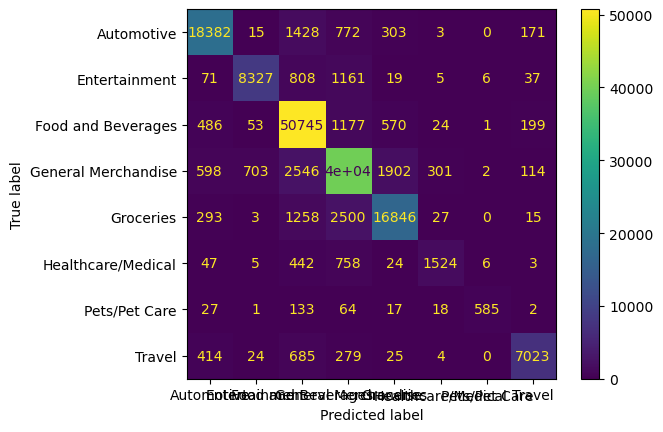

In [195]:
ConfusionMatrixDisplay.from_predictions(y_test_encoded, y_pred, display_labels=le.classes_)
plt.show()

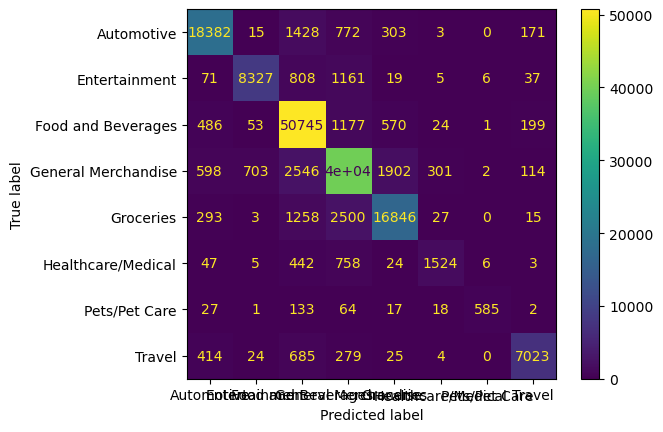

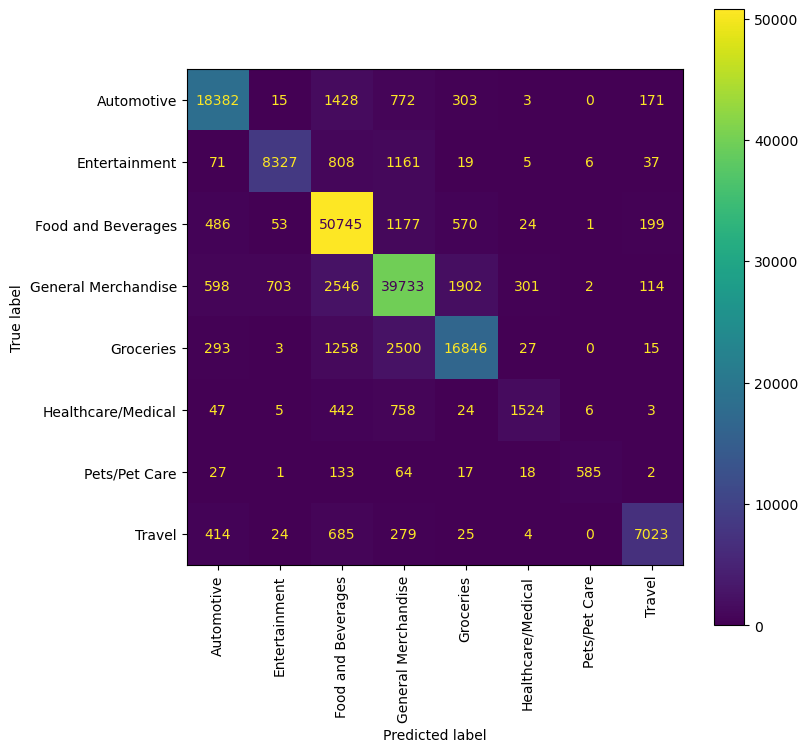

In [211]:
disp = ConfusionMatrixDisplay.from_predictions(y_test_encoded, y_pred, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(8, 8))  # adjust the figure size
font_size = 10  # adjust the font size
disp.plot(include_values=True, ax=ax, xticks_rotation='vertical', values_format='.0f')
ax.set_xticklabels(disp.display_labels, fontsize=font_size, ha='center')  # adjust the font size and alignment
plt.show()

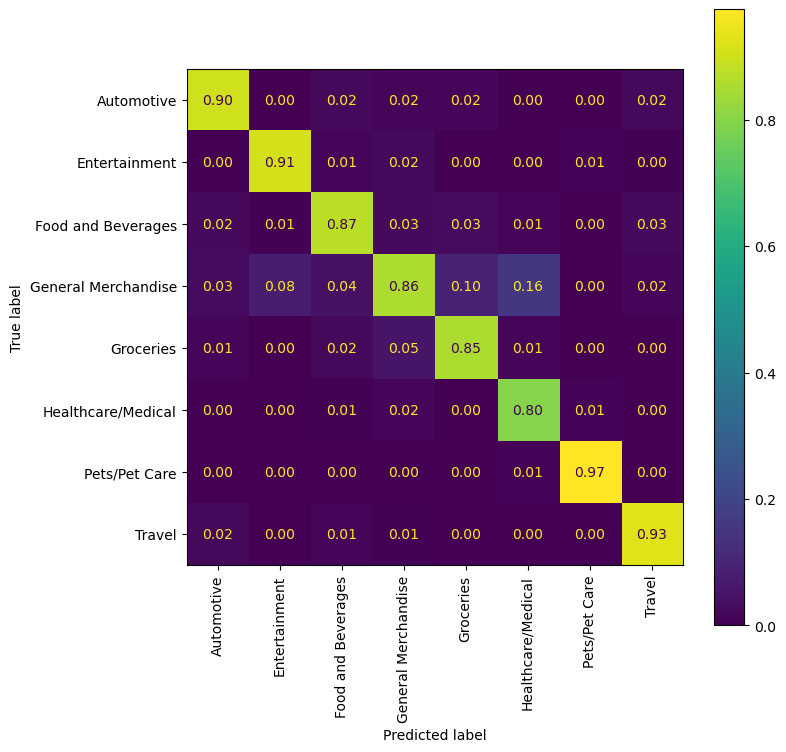

In [248]:
cm = confusion_matrix(y_test_encoded, y_pred, normalize='pred')#.round(2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(8, 8))  # adjust the figure size
font_size = 10  # adjust the font size
disp.plot(include_values=True, ax=ax, xticks_rotation='vertical', values_format='.2f')
ax.set_xticklabels(disp.display_labels, fontsize=font_size, ha='center')  # adjust the font size and alignment
plt.show()

In [244]:
cm.round(2)

array([[0.9 , 0.  , 0.02, 0.02, 0.02, 0.  , 0.  , 0.02],
       [0.  , 0.91, 0.01, 0.02, 0.  , 0.  , 0.01, 0.  ],
       [0.02, 0.01, 0.87, 0.03, 0.03, 0.01, 0.  , 0.03],
       [0.03, 0.08, 0.04, 0.86, 0.1 , 0.16, 0.  , 0.02],
       [0.01, 0.  , 0.02, 0.05, 0.85, 0.01, 0.  , 0.  ],
       [0.  , 0.  , 0.01, 0.02, 0.  , 0.8 , 0.01, 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.98, 0.  ],
       [0.02, 0.  , 0.01, 0.01, 0.  , 0.  , 0.  , 0.93]])

In [240]:
cm = confusion_matrix(y_test_encoded, y_pred, normalize='pred').round(2)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
plt.show()

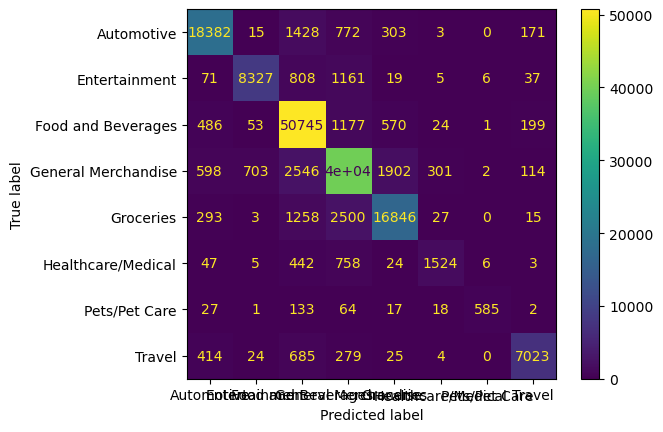

In [241]:
ConfusionMatrixDisplay.from_predictions(y_test_encoded, y_pred, display_labels=le.classes_)
plt.show()

In [201]:
# lr_proba = lr.predict_proba(X_test)
# # final_model = LogisticRegression().fit()
# for weight in range(0,20): # learn weight
#     weighted_average = nontext_proba + weight*tfidf_proba
#     final_df = pd.DataFrame(weighted_average)
# # todo: do a sanity check on this model. look at a specific transaction and trace it
#     final_model = LogisticRegression().fit(final_df, y_test)
    
#     preds = final_model.predict(final_df)
#     print(weight, np.mean(preds == y_test))

In [63]:
# COMPOSITE MODEL DOES NOT WORK
# next week:
# -kyle: think about trying ridge regression
# -try to combine the X_train non-text and text data rather than combining the predictions
# -both text and non-text were already trained on LR so shouldn't be too difficult
# -might have to take it out of the pipeline
# -start working on bert and gpt